In [3]:
import pandas as pd
import numpy as np
df = pd.read_csv("water_potability.csv")
df.head()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
0,NaN,204.890455,20791.318981,7.300212,368.516441,564.308654,10.379783,86.990970,2.963135,0
1,3.716080,129.422921,18630.057858,6.635246,NaN,592.885359,15.180013,56.329076,4.500656,0
2,8.099124,224.236259,19909.541732,9.275884,NaN,418.606213,16.868637,66.420093,3.055934,0
3,8.316766,214.373394,22018.417441,8.059332,356.886136,363.266516,18.436524,100.341674,4.628771,0
4,9.092223,181.101509,17978.986339,6.546600,310.135738,398.410813,11.558279,31.997993,4.075075,0


In [4]:
df.shape

(3276, 10)

There are 3276 rows and 10 columns

In [5]:
df.isnull().sum()

ph                 491
Hardness             0
Solids               0
Chloramines          0
Sulfate            781
Conductivity         0
Organic_carbon       0
Trihalomethanes    162
Turbidity            0
Potability           0
dtype: int64

In [6]:

df= df.dropna()


In [7]:
df.Potability.value_counts()

0    1200
1     811
Name: Potability, dtype: int64

<Axes: ylabel='Potability'>

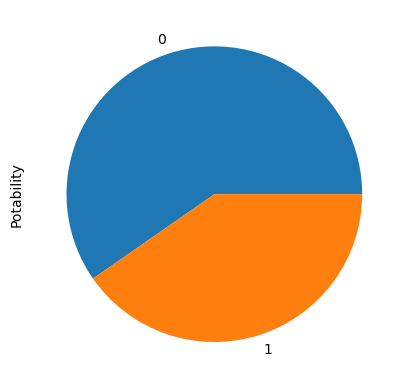

In [8]:
#Plots
import matplotlib.pyplot as plt
import seaborn as sns


df.Potability.value_counts().plot(kind ='pie')

Thus it is an imbalanced dataset, since 0 is much more 1 (1998>1278)
So we need to balance the data so that there is no biasedness.

In [9]:
zero  = df[df['Potability']==0]   
one = df[df['Potability']==1]  
from sklearn.utils import resample

df_minority_upsampled = resample(one, replace = True, n_samples = 1200) 

df = pd.concat([zero, df_minority_upsampled])

from sklearn.utils import shuffle
df = shuffle(df) 

In [ ]:
df.Potability.value_counts().plot(kind ='pie')

Now it's perfect!

In [ ]:

plt.figure(figsize = (15,9))
sns.heatmap(df.corr(), annot = True)

In [ ]:
sns.scatterplot(x=df["ph"], y=df["Hardness"], hue=df.Potability,
data=df)


In [ ]:
sns.scatterplot(x=df["ph"], y=df["Chloramines"], hue=df.Potability,
data=df)

There is no particular pattern!

In [ ]:
df.corr().abs()['Potability'].sort_values(ascending = False)

highest correlation with Potability is solids with 5.24% only

In [ ]:
X = df.drop(['Potability'], axis = 1)
y = df['Potability']

In [ ]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
features= X.columns
X[features] = sc.fit_transform(X[features])

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from xgboost import XGBClassifier


from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.1)

## Hyper-parameter Tuning ;)

In [ ]:


lr = LogisticRegression(random_state=42)

knn = KNeighborsClassifier()

dt = DecisionTreeClassifier()

rf = RandomForestClassifier()

ada = AdaBoostClassifier()

xgb =XGBClassifier(eval_metric = 'logloss', use_label_encoder=False)


para_knn = {'n_neighbors':np.arange(1, 50)} 
grid_knn = GridSearchCV(knn, param_grid=para_knn, cv=5)

#parameters for decision tree
para_dt = {'criterion':['gini','entropy'],'max_depth':np.arange(1, 50), 'min_samples_leaf':[1,2,4,5,10,20,30,40,80,100]}
grid_dt = GridSearchCV(dt, param_grid=para_dt, cv=5) #grid search decision tree for 5 fold cv



params_rf = {'n_estimators':[100,200, 350, 500], 'min_samples_leaf':[2, 10, 30]}
grid_rf = GridSearchCV(rf, param_grid=params_rf, cv=5)

#parameters fpr AdaBoost
params_ada = {'n_estimators': [50,100,250,400,500,600], 'learning_rate': [0.2,0.5,0.8,1]}
grid_ada =  GridSearchCV(ada, param_grid=params_ada, cv=5)

#XGBoost
#parameters for xgboost
params_xgb = {'n_estimators': [50,100,250,400,600,800,1000], 'learning_rate': [0.2,0.5,0.8,1]}
rs_xgb =  RandomizedSearchCV(xgb, param_distributions=params_xgb, cv=5)


In [ ]:
grid_knn.fit(X_train, y_train)
grid_dt.fit(X_train, y_train)
grid_rf.fit(X_train, y_train)
grid_ada.fit(X_train, y_train)
rs_xgb.fit(X_train, y_train)

print("Best parameters for KNN:", grid_knn.best_params_)
print("Best parameters for Decision Tree:", grid_dt.best_params_)
print("Best parameters for Random Forest:", grid_rf.best_params_)
print("Best parameters for AdaBoost:", grid_ada.best_params_)
print("Best parameters for XGBoost:", rs_xgb.best_params_)

 We got the best parameters.

#### Applying bagging and boosting

In [ ]:
lr = LogisticRegression(random_state=42)
dt = DecisionTreeClassifier(criterion='entropy', max_depth=42, min_samples_leaf=1, random_state=42)
knn = KNeighborsClassifier(n_neighbors=1)
rf = RandomForestClassifier(n_estimators=100, min_samples_leaf=2, random_state=42)
ada = AdaBoostClassifier(n_estimators= 600, learning_rate= 1 )
xgb = XGBClassifier(n_estimators= 250, learning_rate= 0.8)

#let's also apply bagging and boosting
bagging = BaggingClassifier(DecisionTreeClassifier(criterion='entropy', max_depth=46, min_samples_leaf=2, random_state=42),
                           n_estimators = 100, random_state = 42)
bagging.fit(X_train, y_train)


In [ ]:
classifiers = [('Logistic Regression', lr), ('K Nearest Neighbours', knn),
               ('Decision Tree', dt), ('Random Forest', rf), ('AdaBoost', ada),
              ('Bagging Classifier', bagging), ('XGBoost', xgb)]


In [ ]:
from sklearn.metrics import accuracy_score

for classifier_name, classifier in classifiers:
 
    # Fit clf to the training set
    classifier.fit(X_train, y_train)    
   
    # Predict y_pred
    y_pred = classifier.predict(X_test)
    accuracy = accuracy_score(y_test,y_pred)
    

   
    # Evaluate clf's accuracy on the test set
    print('{:s} : {:.2f}'.format(classifier_name, accuracy))

Random Forest has performed better.

In [ ]:
from sklearn.metrics import classification_report

y_pred_rf= rf.predict(X_test)
print(classification_report(y_test, y_pred_rf))


The precision of class 0 is 89% and that of class 1 is 90%
It means the model predicts 89% of class 0 and 90% of class 1 correctly

Accuracy is 89%